In [191]:
%load_ext autoreload
%autoreload 2
from data import *
from visualisation2 import *
import numpy as np
# from analysis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


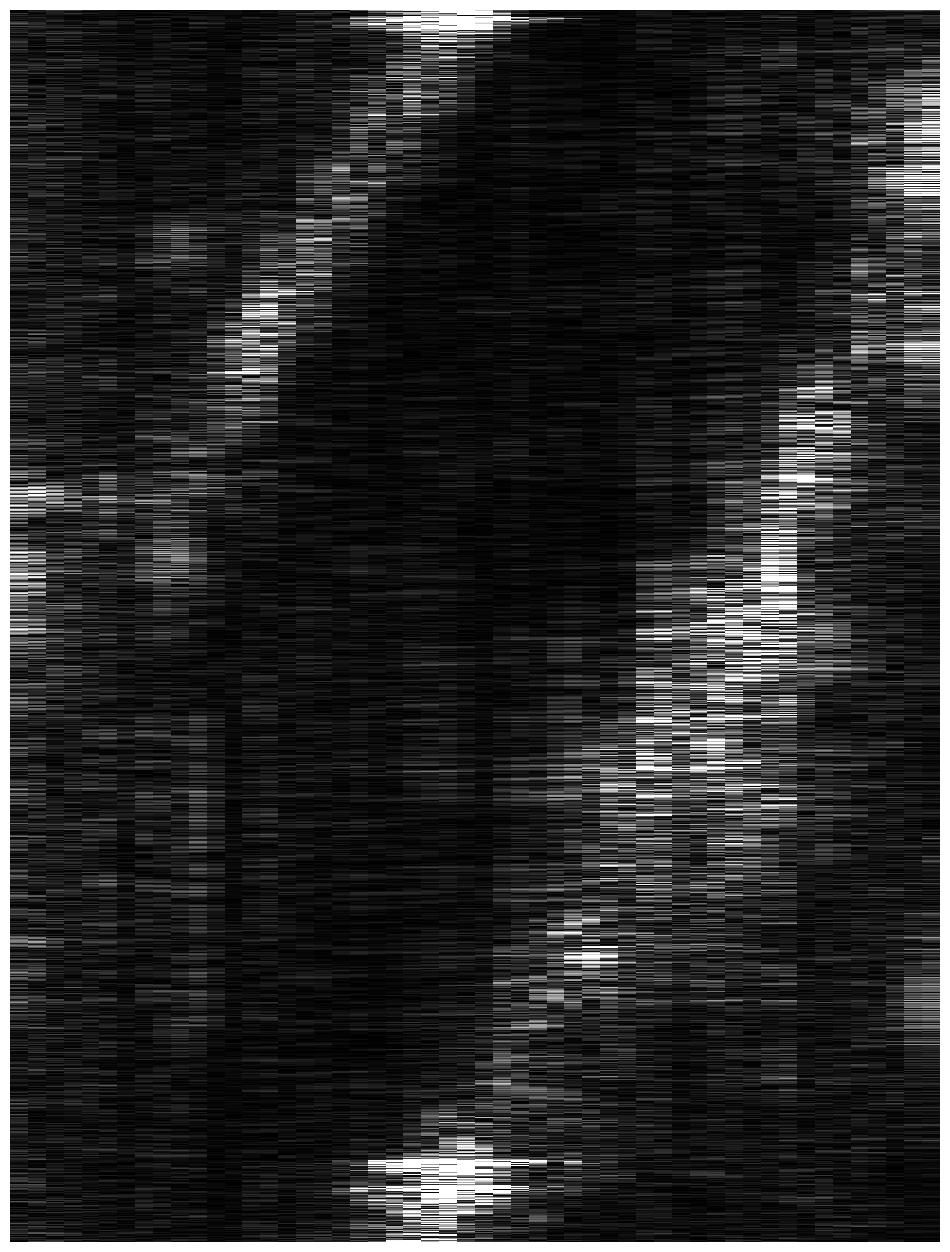

In [192]:
import numpy as np
from visualisation import plot_timeframe
import numpy as np
from data import load_from_file, prepocess

import cv2

filename = "090332.npy"

data = load_from_file(filename)
# plot_timeframe(data)

img = data.to_numpy()

img = prepocess(img)
original_img = img.copy()

plot_numpy(img)




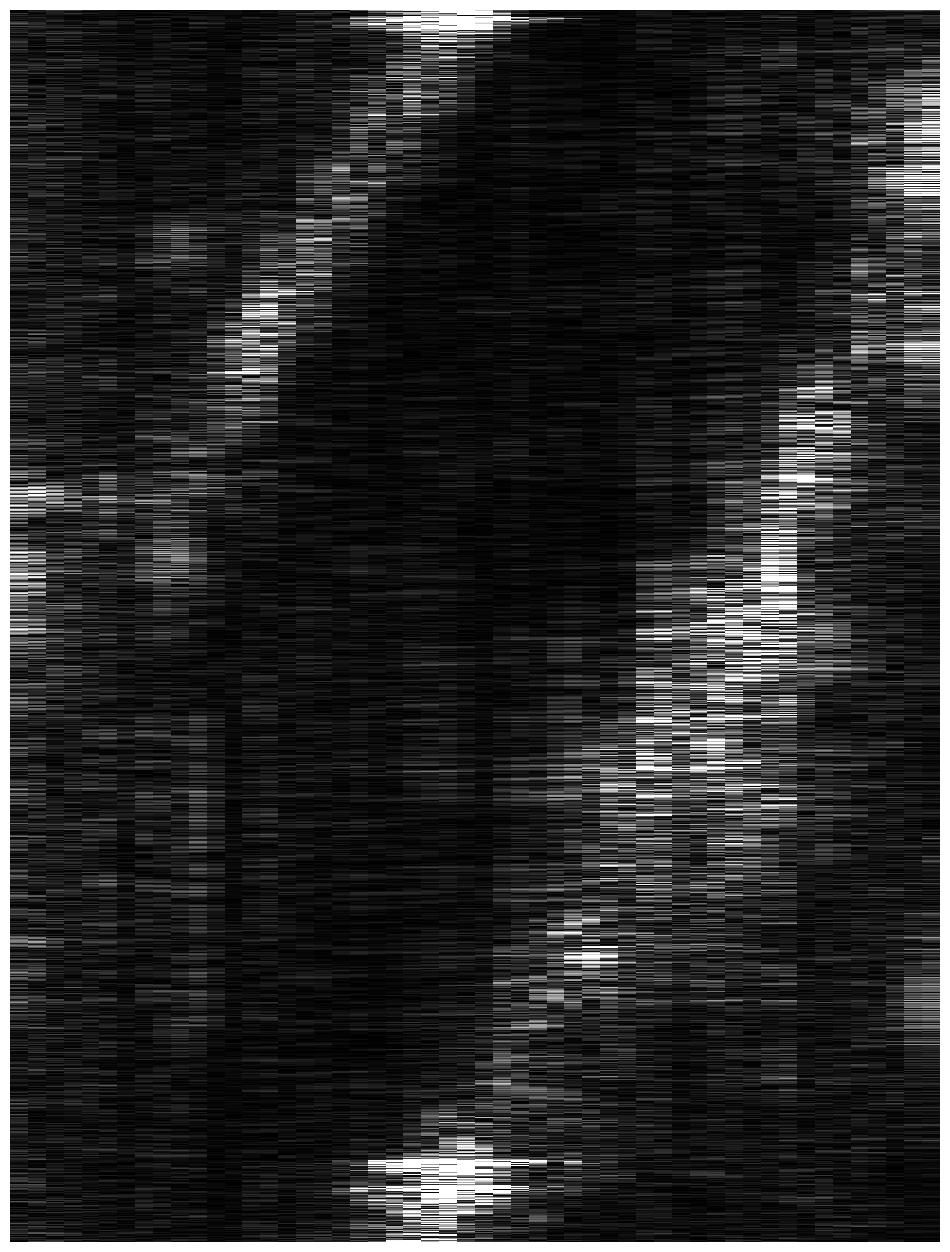

In [193]:
# aspect_ratio = 12/16

# h,w = img.shape

# new_w = int(aspect_ratio * h)

# img = cv2.resize(img, (h,new_w), interpolation=cv2.INTER_NEAREST)

plot_numpy(img)


In [194]:
# img = data.to_numpy()
# img = prepocess(img)

# img = cv2.morphologyEx(
#     img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=1
# )

# plot_numpy(img)

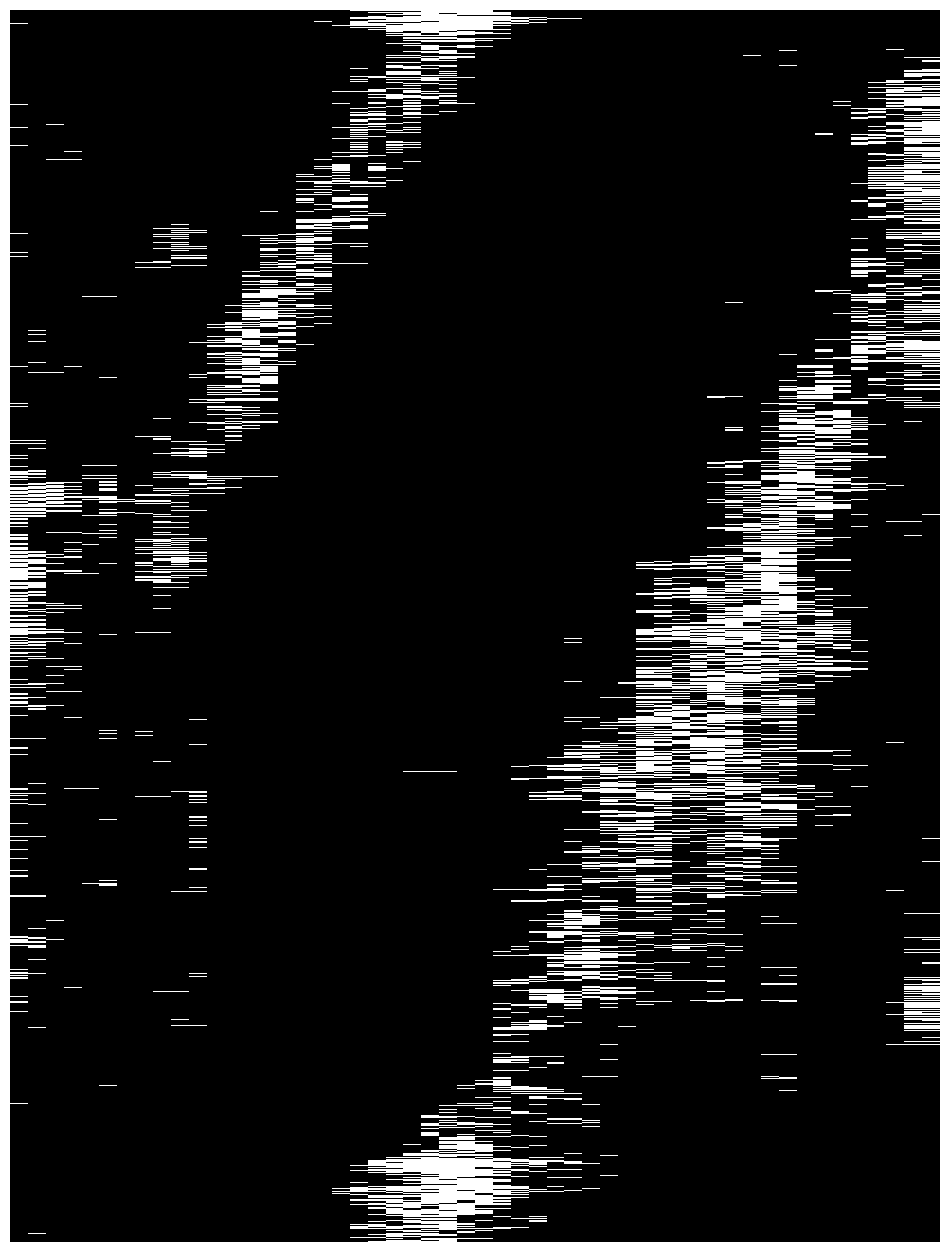

In [195]:
tr, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


plot_numpy(img)

In [196]:
def proper_opening(image, kernel=(3,3)):
    close1 = cv2.morphologyEx(
        image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=1
    )
    open1 = cv2.morphologyEx(
        close1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=1
    )
    close2 = cv2.morphologyEx(
        open1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=1
    )
    return np.minimum(image, close2)


img = proper_opening(img, kernel=(3,3))

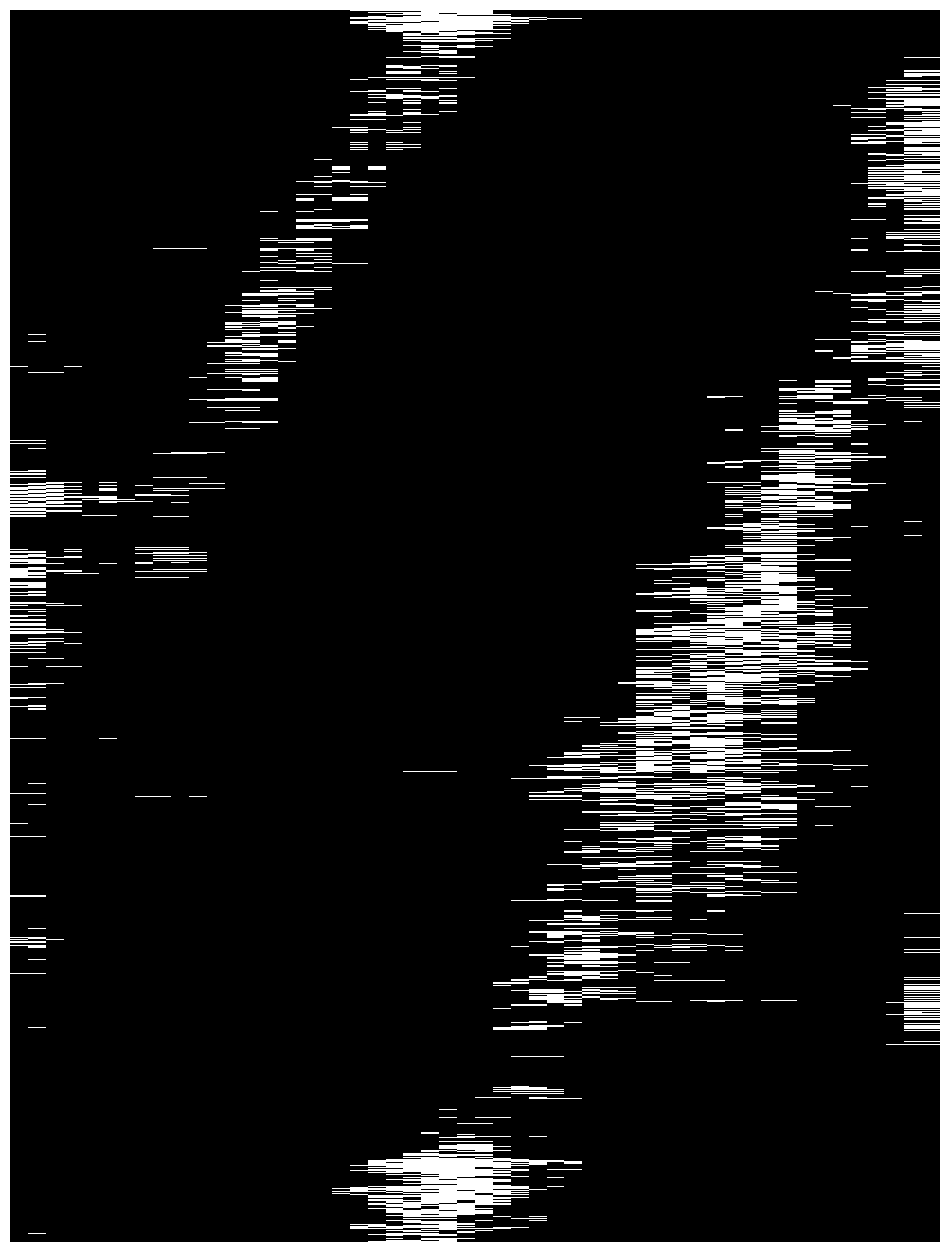

In [197]:
plot_numpy(img)

In [198]:
img.shape

(6250, 52)

In [199]:
def generate_colors(num_colors):
    hsv_colors = [(i / num_colors, 1.0, 1.0) for i in range(num_colors)]
    rgb_colors = [plt.cm.hsv(h)[:3] for h, _, _ in hsv_colors]
    rgb_colors = (np.array(rgb_colors) * 255).astype(np.uint8)
    np.random.shuffle(rgb_colors)
    return rgb_colors

In [200]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

X = np.nonzero(img)
X = np.vstack(X).T

X.shape
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
clustering = DBSCAN(eps=0.08, min_samples=300).fit(X_scaled)

no_of_clusters = np.max(clustering.labels_)+1
print(no_of_clusters)


3


Number of clusters:  3


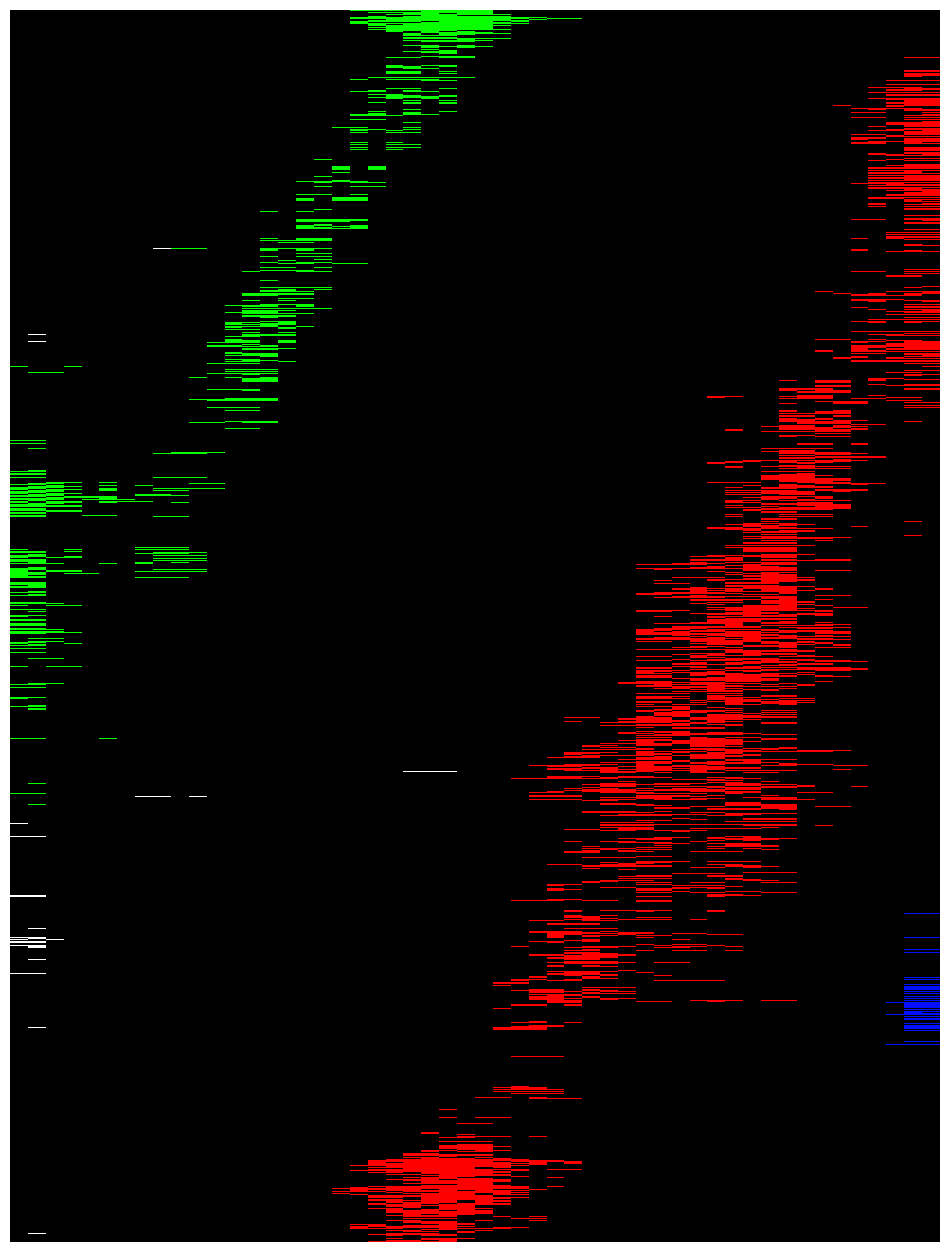

In [201]:
colors = generate_colors(no_of_clusters) 
img_clusters = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

print("Number of clusters: ", no_of_clusters)
for cluster_id in range(no_of_clusters):
    idx = X[clustering.labels_ == cluster_id, :]
    # print(idx)
    # print(f"Cluster{cluster_id}: {np.sum(idx)} members")
    img_clusters[idx.T[0], idx.T[1],:] = colors[cluster_id]

plot_numpy(img_clusters)

R2 of cluster 0: 0.9054616716142634
R2 of cluster 1: 0.8595774276080591
R2 of cluster 2: 0.004732949644665085
Discarded cluster 2 with R2=0.004732949644665085


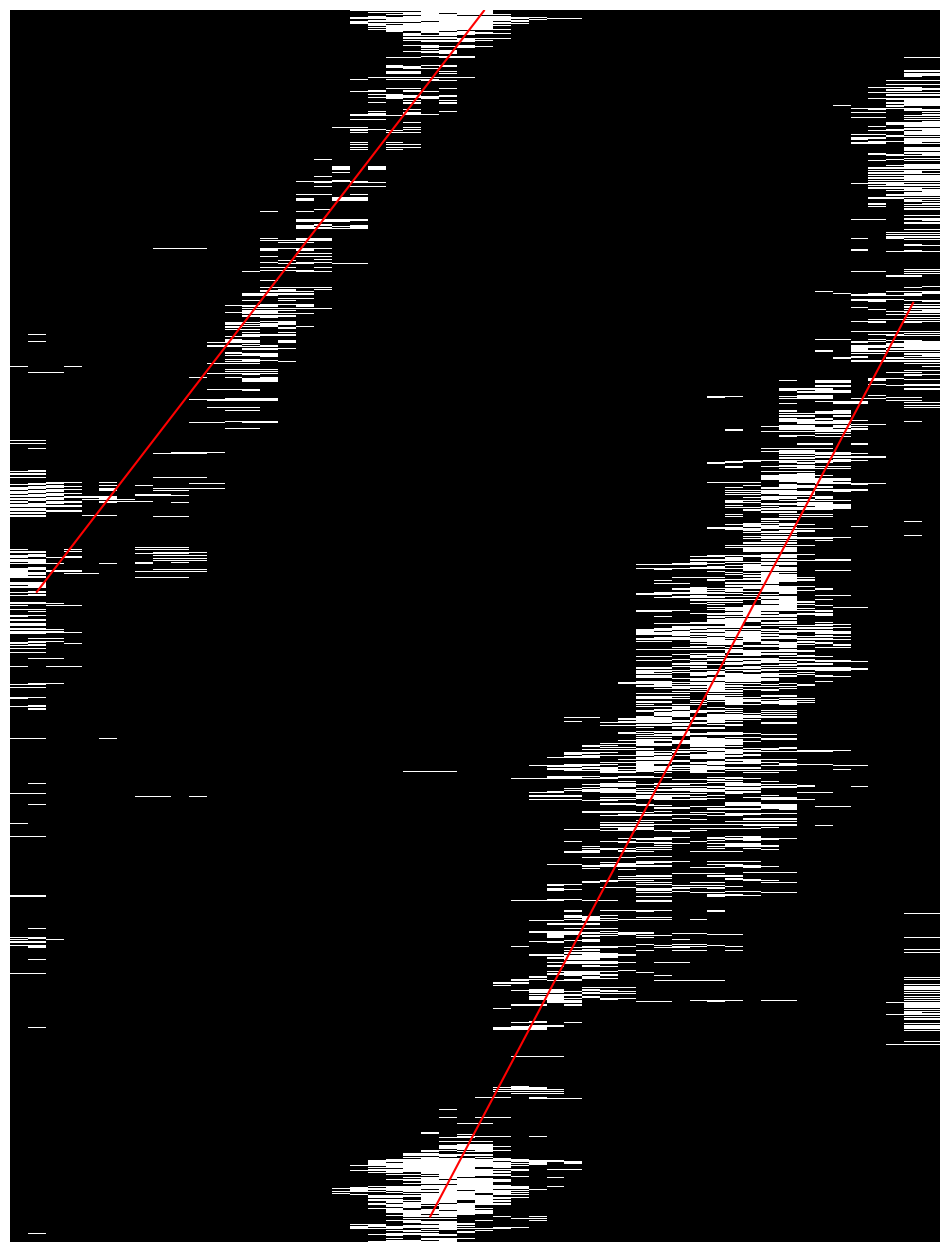

In [204]:
from sklearn.linear_model import LinearRegression

lines = []

for cluster_id in range(no_of_clusters):
    cluster_img = np.zeros_like(img, dtype=np.uint8)
    idx = X[clustering.labels_ == cluster_id, :]
    cluster_img[idx.T[0], idx.T[1]] = 255

    # plot_numpy(C1)
    white_pixels = np.nonzero(cluster_img)
    x_coords = white_pixels[1].reshape(-1,1)
    y_coords = white_pixels[0]

    model = LinearRegression()
    model.fit(x_coords, y_coords)

    slope = model.coef_[0]
    intercept = model.intercept_

    x_start = np.min(x_coords)
    x_end = np.max(x_coords)
    
    # y_start = model.predict([[x_start]])
    # y_end = model.predict([[x_end]])
    r2 = model.score(x_coords, y_coords)
    print(f"R2 of cluster {cluster_id}: {r2}")

    #DISCARDING R2 < 0.8
    if r2 < 0.8:
        print(f"Discarded cluster {cluster_id} with R2={r2}")
        continue
        
    lines.append((slope,intercept, x_start, x_end))
    
# line_dst = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

plot_numpy_with_lines(img, lines)



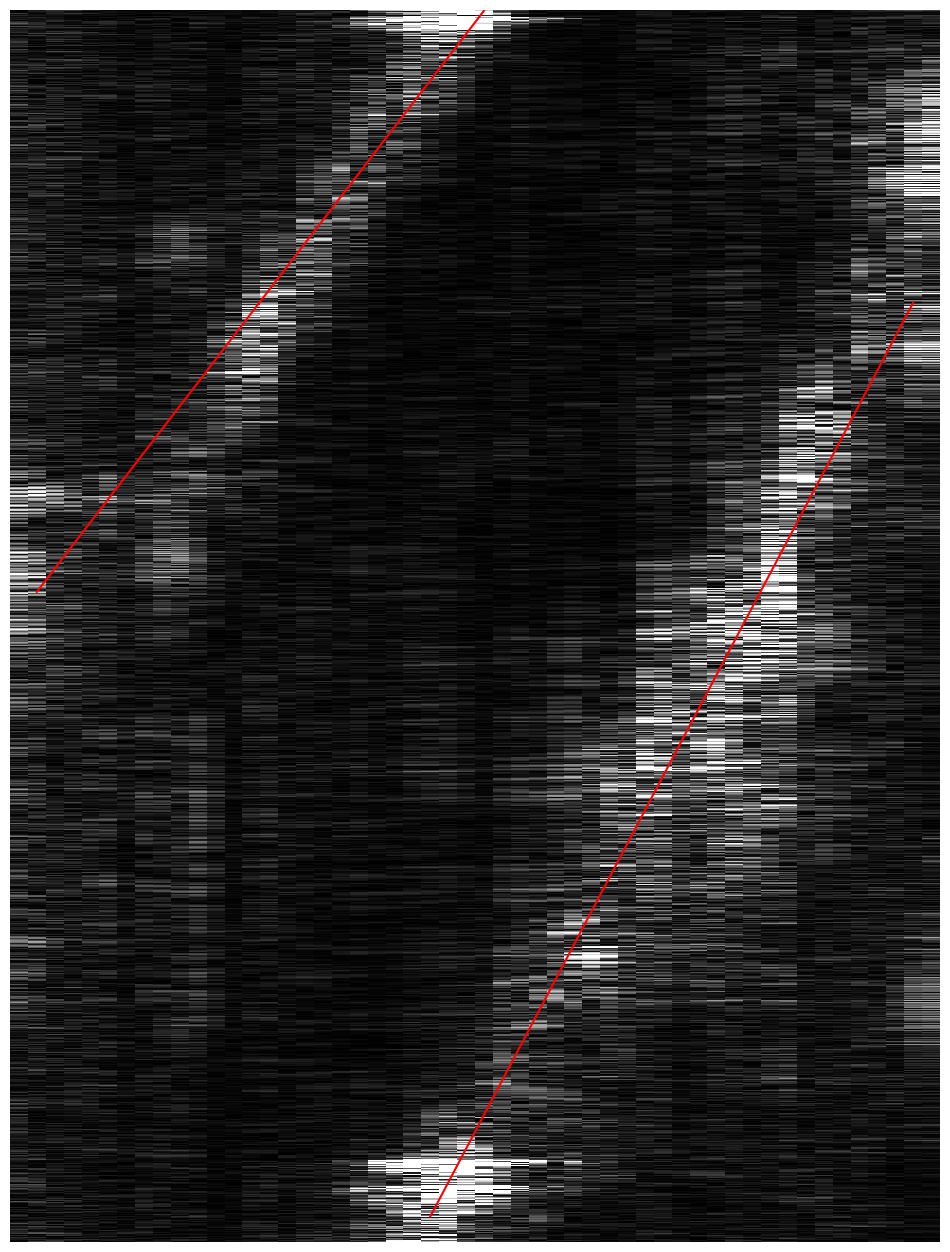

In [205]:
plot_numpy_with_lines(original_img, lines)